# baostock证券数据集下使用LSTM模型预测A股走势

作者信息：[edencfc](https://github.com/edencfc)

更新日期：2022 年 11 月 10 日

摘要: 本示例将会演示如何使用飞桨完成多变量输入的时序数据预测任务。**这个任务以一只A股的价格走势作为示例，将会构建一个LSTM网络预测其未来的涨跌情况。**

--

## 1. 简要介绍

本示例将实现在[证券宝](www.baostock.com)上基于股票的历史走势信息，对未来一个交易日的涨跌的趋势进行预测。

## 2. 环境设置

本示例基于PaddlePaddle 2.4.0 编写，如果你的环境不是本版本，请先参考官网安装 PaddlePaddle 2.4.0。

In [2]:
!pip install dnutils
!pip install mpl_finance

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_finance import candlestick2_ochl
from dnutils import ifnone
from sklearn.preprocessing import MinMaxScaler

# 导入 paddle
import paddle
import paddle.nn.functional as F
print(paddle.__version__)

import warnings
warnings.filterwarnings("ignore")

## 3. 数据集

### 3.1 数据下载与查看
证券宝 www.baostock.com 是一个免费、开源的证券数据平台（无需注册）。其优点请访问[官网](http://baostock.com/baostock/index.php/首页)。

In [ ]:
# 安装baostock库
!pip install baostock -i https://pypi.tuna.tsinghua.edu.cn/simple/ --trusted-host pypi.tuna.tsinghua.edu.cn

下载一只股票的k线数据，这里取sz.002648 15年以后的数据。

In [ ]:
import baostock as bs

#### 登陆系统 ####
lg = bs.login()

#### 获取沪深A股历史K线数据 ####
# 详细指标参数，参见“历史行情指标参数”章节；“分钟线”参数与“日线”参数不同。
# 分钟线指标：date,time,code,open,high,low,close,volume,amount,adjustflag
rs = bs.query_history_k_data_plus("sz.002648",
    "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST",
    start_date='2015-01-01', end_date='2020-4-14',
    frequency="d", adjustflag="3")

#### 打印结果集 ####
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
df = pd.DataFrame(data_list, columns=rs.fields)

print(df)

#### 登出系统 ####
bs.logout()

In [ ]:
df.to_csv("history_A_stock_k_data.csv", index=False)

在我们获取的历史A股K线数据中，各参数名称含义如下：

- open 开盘价 
- high 最高价 
- low 最低价 
- close 收盘价
- preclose	昨日收盘价
- amount	成交金额
- pctChg	涨跌幅（百分比）

In [5]:
df = pd.read_csv("history_A_stock_k_data.csv")
float_type = ['open','high','low','close','preclose','amount','pctChg']

for item in float_type:
    df[item] = df[item].astype('float')

df['amount'] = df['amount'].astype('int')
df['volume'] = df['volume'].astype('int')
df['turn'] = [0 if x == "" else float(x) for x in df["turn"]]
df['buy_flag'] = 10

In [3]:
df.tail()

,date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST,buy_flag
1281,2020-04-08,sz.002648,13.74,14.12,13.65,13.97,13.84,15477705,214734917,3,1.4908,1,0.9393,0,10
1282,2020-04-09,sz.002648,14.08,14.29,14.03,14.18,13.97,16011717,226975113,3,1.5423,1,1.5032,0,10
1283,2020-04-10,sz.002648,14.05,14.05,13.54,13.76,14.18,17320147,238855999,3,1.6694,1,-2.9619,0,10
1284,2020-04-13,sz.002648,14.19,15.14,14.00,14.96,13.76,56552045,834440561,3,5.4507,1,8.7209,0,10
1285,2020-04-14,sz.002648,15.06,15.20,14.80,14.89,14.96,42736530,638906444,3,4.1191,1,-0.4679,0,10


### 3.2 时间序列数据的展示
绘制股票K线图

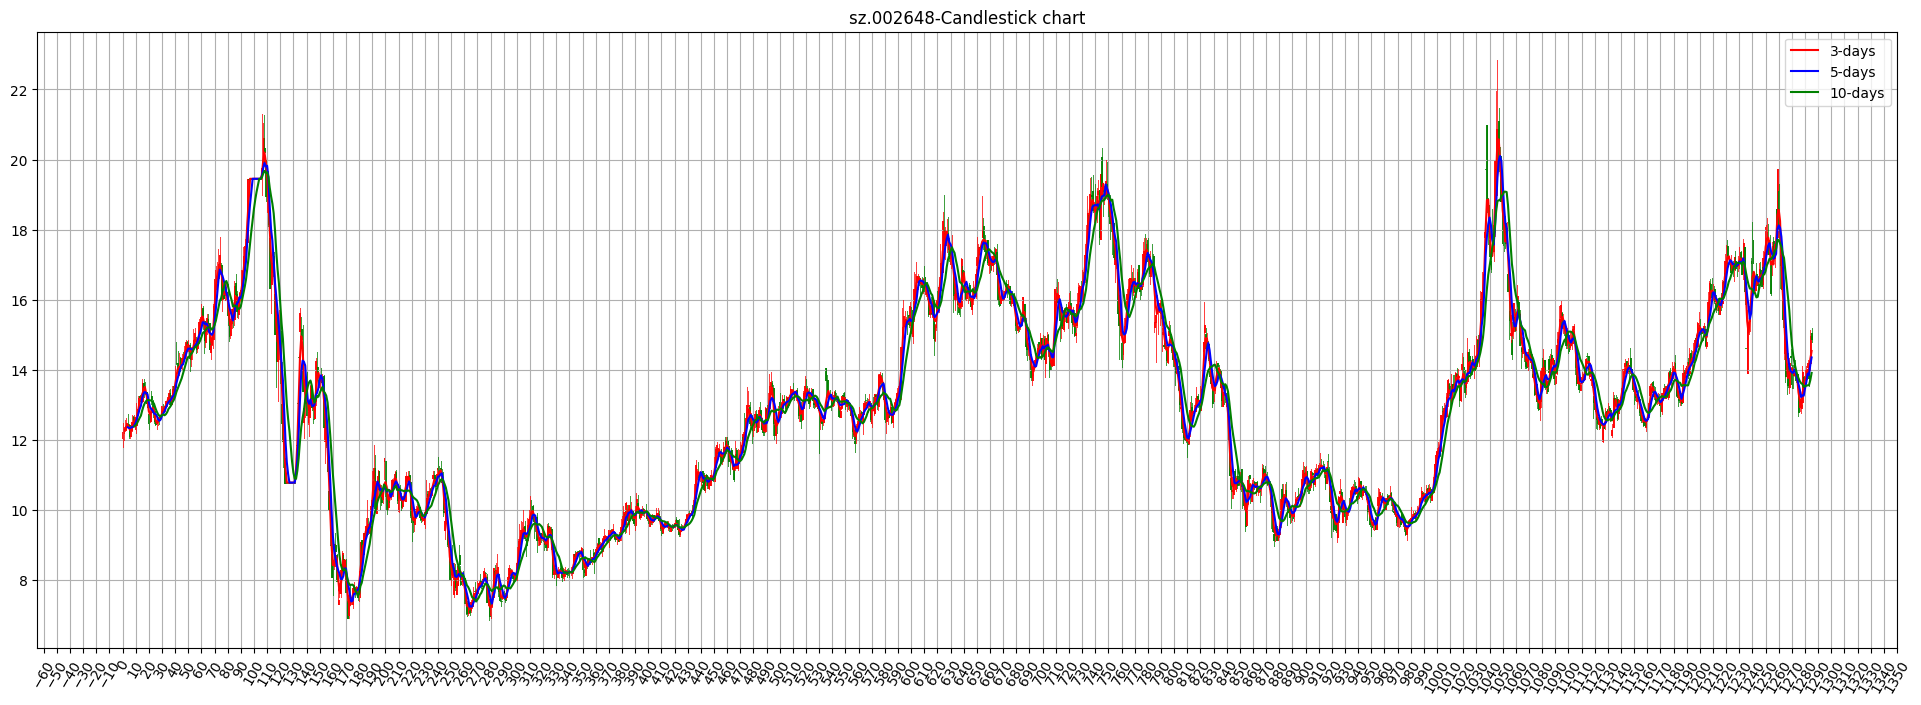

In [15]:
fig, ax = plt.subplots(figsize=(24, 8))
xmajorLocator = MultipleLocator(10)     # 将x轴主刻度设置为5的倍数
ax.xaxis.set_major_locator(xmajorLocator)
# 调用方法绘制K线图
candlestick2_ochl(ax = ax, opens=df["open"].values,closes=df["close"].values, highs=df["high"].values, lows=df["low"].values,width=0.75, colorup='red', colordown='green')
# 如下是绘制3种均线
df['close'].rolling(window=3).mean().plot(color="red",label='3-days')
df['close'].rolling(window=5).mean().plot(color="blue",label='5-days')
df['close'].rolling(window=10).mean().plot(color="green",label='10-days')
plt.legend(loc='best')     # 绘制图例
ax.grid(True)     # 带网格线
plt.title("sz.002648-Candlestick chart")
plt.setp(plt.gca().get_xticklabels(), rotation=60)
plt.show()

### 3.3 数据集的处理
用 LSTM 预测价格显示是不合理的，因为价格的波动非常不可控，所以我们退而求其次，预测股票的走势，即涨还是跌。

但是怎么量化股票的涨跌是个问题，这里我们用未来数天的平均股价表示股票的起伏。

In [4]:
#未来n天移动平均，包含今天
def MA_next(df, date_idx, price_type, n): 
    return df[price_type][date_idx:date_idx+n].mean()

假设短期2天，中期6天，长期15天。如果未来15天平均价格大于未来6天平均价格大于未来2天平均价格，我们就可认为未来15天的股市走势很好。
这里还要求有3%的涨幅，能一定程度上减少标签频繁波动。

`2` 含义为买入，`0` 含义为卖出，`1` 为默认值

In [5]:
s_time = 2
m_time = 6
l_time = 15

for i in range(len(df)-l_time):
    if MA_next(df,i,'close',l_time)>MA_next(df,i,'close',m_time)*1.03>MA_next(df,i,'close',s_time)*1.03:
        df.loc[i, 'buy_flag'] = 2
    elif MA_next(df,i,'close',s_time)>MA_next(df,i,'close',m_time):
        df.loc[i, 'buy_flag'] = 0
    else:
        df.loc[i, 'buy_flag'] = 1
# df.loc[i, 'buy_flag'] = 1 + (MA_next(df,i,'close',m_time)-MA_next(df,i,'close',s_time))/MA_next(df,i,'close',s_time)
#     df.loc[i, 'buy_flag'] = 10*(MA_next(df,i,'close',m_time)+MA_next(df,i,'close',l_time)-2*MA_next(df,i,'close',s_time))/MA_next(df,i,'close',s_time)

In [6]:
df.head()

,date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST,buy_flag
0,2015-01-05,sz.002648,12.04,12.47,11.80,12.22,12.10,16718083,201474357,3,2.089760,1,0.9917,0,1
1,2015-01-06,sz.002648,12.20,12.36,12.00,12.29,12.22,7965196,97122442,3,0.995649,1,0.5728,0,0
2,2015-01-07,sz.002648,12.29,12.56,12.25,12.40,12.29,7684398,95370790,3,0.960550,1,0.8950,0,0
3,2015-01-08,sz.002648,12.43,12.63,12.30,12.47,12.40,8056201,100447582,3,1.007025,1,0.5645,0,0
4,2015-01-09,sz.002648,12.46,12.74,12.39,12.41,12.47,7648582,96383568,3,0.956073,1,-0.4812,0,2


通过使用函数`add_datepart`，能计算当前日期的年、月、日、一周第几天、周数、月初月末、一年当中的第几天等信息。本项目用该函数扩展日期特征。

In [7]:
def make_date(df, date_field):
    "Make sure `df[date_field]` is of the right date type."
    field_dtype = df[date_field].dtype
    if isinstance(field_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        field_dtype = np.datetime64
    if not np.issubdtype(field_dtype, np.datetime64):
        df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)

In [8]:
def add_datepart(df, field_name, prefix=None, drop=True, time=False):
    "Helper function that adds columns relevant to a date in the column `field_name` of `df`."
    make_date(df, field_name)
    field = df[field_name]
    prefix = ifnone(prefix, re.sub('[Dd]ate$', '', field_name))
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    # Pandas removed `dt.week` in v1.1.10
    week = field.dt.isocalendar().week.astype(field.dt.day.dtype) if hasattr(field.dt, 'isocalendar') else field.dt.week
    for n in attr: df[prefix + n] = getattr(field.dt, n.lower()) if n != 'Week' else week
    mask = ~field.isna()
    df[prefix + 'Elapsed'] = np.where(mask,field.values.astype(np.int64) // 10 ** 9,np.nan)
    if drop: df.drop(field_name, axis=1, inplace=True)
    return df

接下来我们为数据生成序列，用前`seq_length`天的信息作为输入序列，后1天的股市起伏`buy_flag`作为标签

In [9]:
# 增加日期特征
add_datepart(df, "date", drop=False)
seq_length = 30
train_df = df[seq_length:-seq_length]
# 丢掉不重要的特征
train_df = train_df.drop(['date','code','Is_month_end', 'Is_month_start', 'Is_quarter_end',
                          'Is_quarter_start', 'Is_year_end', 'Is_year_start','Dayofyear'],axis=1)
train_df

,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST,buy_flag,Year,Month,Week,Day,Dayofweek,Elapsed
30,12.71,12.98,12.71,12.96,12.71,5770104,74291846,3,0.721263,1,1.9670,0,1,2015,2,8,16,0,1.424045e+09
31,12.91,13.03,12.81,12.85,12.96,6220856,80278113,3,0.777607,1,-0.8488,0,2,2015,2,8,17,1,1.424131e+09
32,12.96,13.05,12.81,12.98,12.85,5312105,68837078,3,0.664013,1,1.0117,0,2,2015,2,9,25,2,1.424822e+09
33,13.06,13.12,12.93,13.10,12.98,5018504,65452934,3,0.627313,1,0.9245,0,2,2015,2,9,26,3,1.424909e+09
34,13.10,13.21,12.98,13.14,13.10,6979773,91398700,3,0.872472,1,0.3053,0,2,2015,2,9,27,4,1.424995e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,17.83,18.34,17.30,17.93,18.07,29110138,520609289,3,2.803900,1,-0.7748,0,0,2020,2,9,25,1,1.582589e+09
1252,17.70,18.16,17.29,17.31,17.93,21852389,385795589,3,2.104800,1,-3.4579,0,0,2020,2,9,26,2,1.582675e+09
1253,17.55,17.84,17.22,17.51,17.31,15933944,279989314,3,1.534800,1,1.1554,0,1,2020,2,9,27,3,1.582762e+09
1254,17.10,17.10,16.14,16.19,17.51,26964958,446872846,3,2.597300,1,-7.5385,0,1,2020,2,9,28,4,1.582848e+09


In [10]:
# 数据清洗，填充nan值
train_df= train_df.fillna(0)

### 3.4 构造训练集与验证集

In [11]:
def sliding_windows(data, label, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = label[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [12]:
# 数据归一化
y_scaler = MinMaxScaler()
x_scaler = MinMaxScaler()

X = train_df.drop(['buy_flag'],axis=1).values
X = x_scaler.fit_transform(X)
Y = train_df['buy_flag']
Y = np.array(Y).reshape(-1,1)

x, y = sliding_windows(X, Y, seq_length)

y_train,y_test = y[:int(y.shape[0]*0.8)],y[int(y.shape[0]*0.8):]
x_train,x_test = x[:int(x.shape[0]*0.8)],x[int(x.shape[0]*0.8):]

In [14]:
class MyDataset(paddle.io.Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self, x, y):
        """
        步骤二：实现 __init__ 函数，初始化数据集，将样本和标签映射到列表中
        """
        super(MyDataset, self).__init__()
        self.data = paddle.to_tensor(x.transpose(1,0,2), dtype='float32')
        self.label = paddle.to_tensor(y, dtype='float32')

    def __getitem__(self, index):
        """
        步骤三：实现__getitem__函数，定义指定index时如何获取数据，并返回单条数据（样本数据、对应的标签）
        """
        data = self.data[index]
        label = self.label[index]
        return data, label

    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        return len(self.data)

# 实例化数据集
train_dataset = MyDataset(x_train, y_train)
eval_dataset = MyDataset(x_test, y_test)

In [15]:
# 查看数据样本
x_train[0][8]

array([0.4398017 , 0.40102828, 0.48767334, 0.46743021, 0.45096636,
       0.15679451, 0.10256025, 0.        , 0.20306253, 1.        ,
       0.58623833, 0.        , 0.        , 0.18181818, 0.17307692,
       0.13333333, 0.75      , 0.00923411])

In [16]:
x_train.shape

(956, 30, 18)

In [17]:
y_train.shape

(956, 1)

## 4. 模型组网

本项目构造了简单的LSTM层，具体步骤如下：

1. 连接LSTM层，从时间步的维度进行时序建模。
2. 通过全连接层输出预测值。
3. 模型的损失函数选择为均方误差，优化方法采用adam优化器。

In [42]:
class LSTM(paddle.nn.Layer):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length       
        self.lstm = paddle.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers)
        # self.relu = paddle.nn.ReLU()
        self.fc = paddle.nn.Linear(hidden_size, num_classes)
        # self.relu = paddle.nn.ReLU()
        # self.head = paddle.nn.Linear(int(hidden_size/2), out_features=num_classes)
        

    def forward(self, x):
        x, (h, c)=self.lstm(x)
        # print(h)
        # x = x[:,-1,:]
        h = h[-1]
        x = self.fc(h) 
        # x = self.head(x)
        # print(out)
        return x

In [21]:
# 打印网络结构
model = LSTM(128,18,300,1)
paddle.summary(model, (30,796,18))

-----------------------------------------------------------------------------------------------------
 Layer (type)       Input Shape                       Output Shape                      Param #    
    LSTM-2        [[30, 796, 18]]    [[30, 796, 300], [[1, 30, 300], [1, 30, 300]]]     384,000    
   Linear-1       [[30, 796, 300]]                   [30, 796, 128]                     38,528     
Total params: 422,528
Trainable params: 422,528
Non-trainable params: 0
-----------------------------------------------------------------------------------------------------
Input size (MB): 1.64
Forward/backward pass size (MB): 78.11
Params size (MB): 1.61
Estimated Total Size (MB): 81.37
-----------------------------------------------------------------------------------------------------



{'total_params': 422528, 'trainable_params': 422528}

## 5. 模型训练

使用模型网络结构和数据集进行模型训练。

在高层API中，可以用 paddle.Model 完成模型封装后，然后通过 Model.prepare 进行训练前的配置准备工作，包括设置优化算法、Loss 计算方法、评价指标计算方法；接着通过Model.fit接口来启动训练。

在训练过程中，需要根据模型训练过程中loss，打印loss下降曲线来调参。为了保存训练时每个batch的loss信息，需要自己定义Callback函数，完成模型训练时loss信息的记录。

In [22]:
# 自定义Callback 需要继承基类 Callback
class LossCallback(paddle.callbacks.Callback):

    def __init__(self):
        self.losses = []
        
    def on_train_begin(self, logs={}):
        # 在fit前 初始化losses，用于保存每个batch的loss结果
        self.losses = []
    
    def on_train_batch_end(self, step, logs={}):
        # 每个batch训练完成后调用，把当前loss添加到losses中
        self.losses.append(logs.get('loss'))
loss_log = LossCallback()

In [43]:
from paddle.static import InputSpec
# 参数设置
num_epochs = 15
learning_rate = 1e-3

input_size = train_df.shape[1]-1 # 输入的变量指标数量
hidden_size = 300 # 隐藏状态 h 大小
num_layers = 1 # 循环网络的层数

num_classes = 1 # 输出的特征数
batch_size = 8

model = paddle.Model(LSTM(num_classes, input_size, hidden_size, num_layers))

lr_schedual = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=learning_rate, T_max=num_epochs, verbose=False)
# 设置优化器，学习率，并且把模型参数给优化器
opt = paddle.optimizer.Adam(learning_rate=learning_rate,parameters=model.parameters(), beta1=0.9, beta2=0.999)

model.prepare(
    opt,
    paddle.nn.MSELoss(),
    paddle.metric.Accuracy()
    )
    
model.fit(train_dataset,
        eval_dataset,
        epochs=num_epochs,
        batch_size=batch_size,
        eval_freq=10, 
        save_freq=10,
        save_dir='lstm_checkpoint',
        verbose=1,
        drop_last=False,
        shuffle=False,
        callbacks=[loss_log]
        )

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/15
step 4/4 [==============================] - loss: 1.4543 - acc: 0.4667 - 45ms/step
save checkpoint at /home/aistudio/lstm_checkpoint/0
Eval begin...
step 4/4 [==============================] - loss: 0.5837 - acc: 0.2667 - 5ms/step
Eval samples: 30
Epoch 2/15
step 4/4 [==============================] - loss: 0.7472 - acc: 0.4667 - 42ms/step
Epoch 3/15
step 4/4 [==============================] - loss: 0.9142 - acc: 0.4667 - 41ms/step
Epoch 4/15
step 4/4 [==============================] - loss: 1.0340 - acc: 0.4667 - 41ms/step
Epoch 5/15
step 4/4 [==============================] - loss: 1.0149 - acc: 0.4667 - 40ms/step
Epoch 6/15
step 4/4 [==============================] - loss: 0.9198 - acc: 0.4667 - 41ms/step
Epoch 7/15
step 4/4 [==============================] - loss: 0.8290 - acc: 0.4667 - 39ms/step
Epoch 8/15
step 4/4 [==============================] - loss: 0.7915

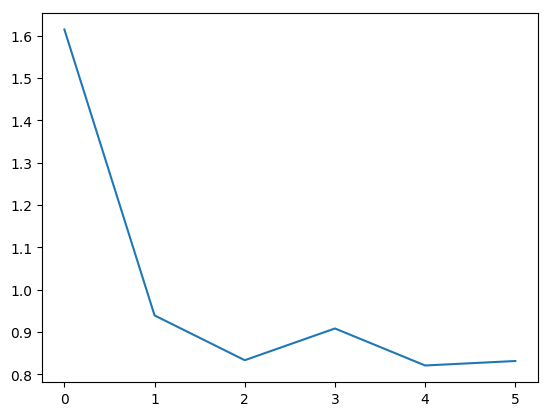

In [44]:
# 可视化 loss
log_loss = [loss_log.losses[i] for i in range(0, len(loss_log.losses), 10)]
plt.figure()
plt.plot(log_loss)

## 6. 模型评估

评估指标(Metric)用来衡量一个模型的效果, 一般是通过计算模型的预测结果和真实结果之间的某种差距。

使用Paddle高层API的Model.evaluate接口可以一键完成模型评估操作，结束后根据在Model.prepare中定义的loss和metric计算并返回相关评估结果。

In [45]:
model.load('lstm_checkpoint/final')
# 用 evaluate 在测试集上对模型进行验证
eval_result = model.evaluate(eval_dataset,batch_size=batch_size, verbose=1)
print(eval_result)

Eval begin...
step 4/4 [==============================] - loss: 0.9008 - acc: 0.2667 - 5ms/step
Eval samples: 30
{'loss': [0.9008147], 'acc': 0.26666666666666666}


## 7. 模型预测

对模型进行预测，展示效果。高层API中提供了Model.predict接口，可对训练好的模型进行推理验证。只需传入待执行推理验证的样本数据，即可计算并返回推理结果。

In [46]:
model.load('lstm_checkpoint/final')
test_result = model.predict(eval_dataset)
# 由于模型是单一输出，test_result的形状为[1, N]，N是测试数据集的数据量。这里打印第一个数据的预测结果。
print(len(test_result))
print(test_result[0][0])
print('预测值:{0}, 实际值:{1}'.format(test_result[0][0][0],eval_dataset[0][1][0]))

Predict begin...
step 30/30 [==============================] - 3ms/step          
Predict samples: 30
1
[[1.2915319]]
预测值:[1.2915319], 实际值:Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [1.])
